In [272]:
import numpy as np
import os
import xarray as xr
from pathlib import Path
import act
import matplotlib.pyplot as plt
import matplotlib
import glob
from datetime import datetime
from datetime import timedelta
%matplotlib inline

print('Reese')

Reese


## Creating directory extensions

In [341]:
in_dir = r"C:\Users\Reese\Desktop\AOS Proj Data"
out_dir = r"C:\Users\Reese\Desktop\AOS Proj Data\Ouput_Files"
pbl_in = "\pblht" #Extension for input directory -- Need Month and year on directory
pbl_out = "\May2019_Neut_Pbl.nc"
smps_May19_in = "\smps\*.nc"
smps_qcInc_out = "\May19SMPSqcUsed.nc"
smps_qcUsed_out = "\May19SMPSqcUsed.nc"
microbase_in = "\microbase\*.nc"
microbase_out = "\Microbase_Neu_ABL.nc"

# Create 4 arrays and create dataset from these
## I assume we wont want to do this in this manner when we think big picture, but I'm not sure how else to do it because we cannot open all of the files into a single dataset (height_ss is neither monotonically increasing nor monotonically decreasing on all datasets) and then subset per pblregime...

In [342]:
#Create arrays
time_arr = []
b4_time = []
aftr_time = []
pbl_hgt = []
# Iterate over files in the directory
directory = in_dir+pbl_in
for filename in os.listdir(directory):
    #Setting path for the given sounding file
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        ds1 = xr.open_dataset(f)
        #Check if regime is neutral
        if ds1['pbl_regime_type_liu_liang'].values == 0.0:
            givent_time = ds1['time'][0].values
            time_arr.append(givent_time)
            b = ds1['time'][0].values - np.timedelta64(90,'m')
            b4_time.append(b)
            a = ds1['time'][0].values + np.timedelta64(90,'m')
            aftr_time.append(a)
            p = ds1['pbl_height_liu_liang'].values
            pbl_hgt.append(p)

### Creating dataset from times (b4, aftr, given) and pbl height ------ Issue!!!

#### ValueError: To proceed, remove this key from the variable's attributes manually.

In [312]:
ds8 = xr.Dataset({
    'launch_time': xr.DataArray(
            data   = time_arr,   # enter data here
            dims   = ['time'],
            coords = {'time': time_arr}#,
            #attrs  = {'long_name': 'Actual time of sonde launch', 'units': 'time'} #Is the what we should remove
            ),
    'b4_time': xr.DataArray(
                data   = b4_time,   # enter data here
                dims   = ['time'],
                coords = {'time': time_arr}#,
                #attrs  = {'long_name': '90 minutes before sonde launch', 'units': 'time'} #Is the what we should remove
                ),
    'aftr_time': xr.DataArray(
                data   = aftr_time,   # enter data here
                dims   = ['time'],
                coords = {'time': time_arr}#,
                #attrs  = {'long_name': '90 minutes after sonde launch', 'units': 'time'}
                ),
    'pbl_hgt': xr.DataArray(
                data   = pbl_hgt,   # enter data here
                dims   = ['time'],
                coords = {'time': time_arr}#,
                #attrs  = {'long_name': 'Height of the PBL for sonde launch', 'units': 'm'}
                )
            },
        attrs = {'example_attr': 'this is a global attribute'}
    )

In [313]:
ds8

<xarray.Dataset>
Dimensions:      (time: 135)
Coordinates:
  * time         (time) datetime64[ns] 2019-04-30T23:32:00 ... 2019-05-31T23:...
Data variables:
    launch_time  (time) datetime64[ns] 2019-04-30T23:32:00 ... 2019-05-31T23:...
    b4_time      (time) datetime64[ns] 2019-04-30T22:02:00 ... 2019-05-31T21:...
    aftr_time    (time) datetime64[ns] 2019-05-01T01:02:00 ... 2019-06-01T00:...
    pbl_hgt      (time) float64 503.9 515.3 481.2 ... 2.856e+03 2.683e+03
Attributes:
    example_attr:  this is a global attribute

In [346]:
ds8.to_netcdf(out_dir+pbl_out,format='NETCDF4')

'C:\\Users\\Reese\\Desktop\\AOS Proj Data\\Ouput_Files\\May2019_Neut_Pbl.nc'

# We need to subset the below smps dataset by time ranges.
### Setting variables to drop for aossmps

In [278]:
drop_vars = ['diameter_mobility','base_time','time_offset','time_bounds','diameter_mobility_bounds', 'lower_size', 'dN_dlogDp', 'qc_dN_dlogDp', 'total_SA_conc', 'qc_total_SA_conc', 'dD_to_dSA',
            'total_V_conc', 'qc_total_V_conc', 'dD_to_dV', 'aerosol_flow', 'bypass_flow', 'sheath_flow', 'delay_time', 'geometric_mean',
            'geometric_std', 'mean', 'median', 'mode', 'sample_temperature', 'sample_relative_humidity', 'sample_pressure', 'mean_free_path',
            'gas_viscosity', 'reference_gas_temperature', 'reference_gas_pressure', 'reference_mean_free_path', 'reference_gas_viscosity',
            'sutherland_constant', 'diffusion_correction', 'multiple_charge_correction', 'nanoparticle_agglomerate_mobility_analysis',
            'status_flag', 'd50', 'low_voltage', 'high_voltage', 'hv_polarity', 'tube_diameter', 'tube_length', 'DMA_inner_radius',
            'DMA_outer_radius', 'DMA_characteristic_length'] 

### Using mfdataset changes the total_N_conc and qc_total_N_conc to dask.array<chunksize=(288),> I'm not sure what this means though when printing the values, they are the same

In [347]:
dsA = act.io.armfiles.read_netcdf(in_dir+smps_May19_in, drop_variables=drop_vars)
#dsA = xr.open_mfdataset(r"C:\Users\Reese\Desktop\AOS Proj Data\smps\*.nc", drop_variables=drop_vars)
dsA

'C:\\Users\\Reese\\Desktop\\AOS Proj Data\\smps\\*.nc'

# Subset smps dataset per the launch times in ds8 with 90 minute tolerance 

In [281]:
aaa = ds8['b4_time'][0].values
bbb = ds8['aftr_time'][0].values
tester = dsA.sel(time=slice(aaa, bbb))

## Second method gets all times and prevents duplicates
### if the start time of an iteration overlaps with the endtime of the previous, we set the new start time to 1 minute after the previous end time

In [282]:
#Setting up an end to the loop
last = len(ds8['b4_time'])

for idx in range(1,last): #Only looping through twenty because we are using three days of data!!
    #Check to see if the new dataset start time occurs BEFORE the ending time of the previous dataset
    if ds8['b4_time'][idx].values <= ds8['aftr_time'][idx-1].values:
        strt = ds8['aftr_time'][idx-1].values + np.timedelta64(1, 'm')
        end = ds8['aftr_time'][idx].values
        temp = dsA.sel(time=slice(strt, end))
        tester = xr.concat([tester, temp], dim='time')
    else:
        strt = ds8['b4_time'][idx].values
        end = ds8['aftr_time'][idx].values
        temp = dsA.sel(time=slice(strt, end))
        tester = xr.concat([tester, temp], dim='time')

#Using the before and after times from the neutral boundary file to subset smps file
#for idx in range(1, last):#NOTE we took the 0 index to make the INITIAL.
#    strt = ds8['b4_time'][idx].values
#    end = ds8['aftr_time'][idx].values
#    temp = dsA.sel(time=slice(strt, end))
#    tester = xr.concat([tester, temp], dim='time')
tester

<xarray.Dataset>
Dimensions:          (time: 4787)
Coordinates:
  * time             (time) datetime64[ns] 2019-05-01 ... 2019-05-31T23:55:00
Data variables:
    total_N_conc     (time) float32 dask.array<chunksize=(13,), meta=np.ndarray>
    qc_total_N_conc  (time) int32 dask.array<chunksize=(13,), meta=np.ndarray>
    lat              (time) float32 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6 36.6
    lon              (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt              (time) float32 318.0 318.0 318.0 ... 318.0 318.0 318.0
Attributes: (12/29)
    command_line:                 aossmpscorr -s sgp -f E13
    Conventions:                  ARM-1.2
    process_version:              ingest-aossmpscorr-1.1-0.el7
    dod_version:                  aossmps-b1-2.1
    site_id:                      sgp
    platform_id:                  aossmps
    ...                           ...
    classifier_serial_number:     3082001529004
    channels_per_decade:          64
    instrument_output_units:      dw/dlogDp
    instrument_output_weighting:  Number
    doi:                          10.5439/1476898
    history:                      created by user dsmgr on machine zinc at 20...

# Just using the xarray dataset object to apply DQR

In [283]:
tester.clean.cleanup()

In [284]:
var2 = 'total_N_conc'
obj2 = act.qc.arm.add_dqr_to_qc(tester, variable = var2)

In [285]:
obj2

<xarray.Dataset>
Dimensions:          (time: 4787)
Coordinates:
  * time             (time) datetime64[ns] 2019-05-01 ... 2019-05-31T23:55:00
Data variables:
    total_N_conc     (time) float32 dask.array<chunksize=(13,), meta=np.ndarray>
    qc_total_N_conc  (time) int32 dask.array<chunksize=(13,), meta=np.ndarray>
    lat              (time) float32 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6 36.6
    lon              (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt              (time) float32 318.0 318.0 318.0 ... 318.0 318.0 318.0
Attributes: (12/29)
    command_line:                 aossmpscorr -s sgp -f E13
    Conventions:                  ARM-1.2
    process_version:              ingest-aossmpscorr-1.1-0.el7
    dod_version:                  aossmps-b1-2.1
    site_id:                      sgp
    platform_id:                  aossmps
    ...                           ...
    classifier_serial_number:     3082001529004
    channels_per_decade:          64
    instrument_output_units:      dw/dlogDp
    instrument_output_weighting:  Number
    doi:                          10.5439/1476898
    history:                      created by user dsmgr on machine zinc at 20...

In [286]:
obj2.clean.normalize_assessment()

In [287]:
obj2

<xarray.Dataset>
Dimensions:          (time: 4787)
Coordinates:
  * time             (time) datetime64[ns] 2019-05-01 ... 2019-05-31T23:55:00
Data variables:
    total_N_conc     (time) float32 dask.array<chunksize=(13,), meta=np.ndarray>
    qc_total_N_conc  (time) int32 dask.array<chunksize=(13,), meta=np.ndarray>
    lat              (time) float32 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6 36.6
    lon              (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt              (time) float32 318.0 318.0 318.0 ... 318.0 318.0 318.0
Attributes: (12/29)
    command_line:                 aossmpscorr -s sgp -f E13
    Conventions:                  ARM-1.2
    process_version:              ingest-aossmpscorr-1.1-0.el7
    dod_version:                  aossmps-b1-2.1
    site_id:                      sgp
    platform_id:                  aossmps
    ...                           ...
    classifier_serial_number:     3082001529004
    channels_per_decade:          64
    instrument_output_units:      dw/dlogDp
    instrument_output_weighting:  Number
    doi:                          10.5439/1476898
    history:                      created by user dsmgr on machine zinc at 20...

# Creating a netCDF file from the dataset

In [288]:
obj2.to_netcdf(out_dir+smps_qcInc_out,format='NETCDF4')

# We also want to make a file with the qc value applied and tossed.
## We will want to use a data filter method.

In [289]:
obj2.qcfilter.datafilter(variables = 'total_N_conc', rm_assessments=['Bad', 'Incorrect', 'Indeterminate', 'Suspect'])

In [290]:
obj2

<xarray.Dataset>
Dimensions:       (time: 4787)
Coordinates:
  * time          (time) datetime64[ns] 2019-05-01 ... 2019-05-31T23:55:00
Data variables:
    total_N_conc  (time) float32 dask.array<chunksize=(37,), meta=np.ndarray>
    lat           (time) float32 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6 36.6
    lon           (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49 -97.49
    alt           (time) float32 318.0 318.0 318.0 318.0 ... 318.0 318.0 318.0
Attributes: (12/29)
    command_line:                 aossmpscorr -s sgp -f E13
    Conventions:                  ARM-1.2
    process_version:              ingest-aossmpscorr-1.1-0.el7
    dod_version:                  aossmps-b1-2.1
    site_id:                      sgp
    platform_id:                  aossmps
    ...                           ...
    classifier_serial_number:     3082001529004
    channels_per_decade:          64
    instrument_output_units:      dw/dlogDp
    instrument_output_weighting:  Number
    doi:                          10.5439/1476898
    history:                      created by user dsmgr on machine zinc at 20...

### Storing object with the qc applied and dropped to a netcdf file

In [291]:
obj2.to_netcdf(out_dir+smps_qcUsed_out,format='NETCDF4')

# We will next work on Cloud Data Product!
## Only using first three days because of size of the files (approx. 1gb a day).

- I dont know why I am dropping basetime here...Did we want to drop ANYTHING?

In [292]:
micro = act.io.armfiles.read_netcdf(in_dir+microbase_in, drop_variables='base_time')
#micro = xr.open_mfdataset(r"C:\Users\Reese\Desktop\AOS Proj Data\microbase\*.nc", drop_variables='base_time')

In [293]:
micro

<xarray.Dataset>
Dimensions:                                  (time: 64800, bound: 2, height: 596)
Coordinates:
  * time                                     (time) datetime64[ns] 2019-05-01...
  * height                                   (height) float32 160.0 ... 1.801...
Dimensions without coordinates: bound
Data variables: (12/27)
    time_offset                              (time) datetime64[ns] dask.array<chunksize=(21600,), meta=np.ndarray>
    time_bounds                              (time, bound) datetime64[ns] dask.array<chunksize=(21600, 2), meta=np.ndarray>
    height_bounds                            (time, height, bound) float32 dask.array<chunksize=(21600, 596, 2), meta=np.ndarray>
    liquid_water_content                     (time, height) float32 dask.array<chunksize=(21600, 596), meta=np.ndarray>
    liquid_water_content_uncertainty_random  (time, height) float32 dask.array<chunksize=(21600, 596), meta=np.ndarray>
    qc_liquid_water_content                  (time, height) int32 dask.array<chunksize=(21600, 596), meta=np.ndarray>
    ...                                       ...
    aqc_precip                               (time) int32 dask.array<chunksize=(21600,), meta=np.ndarray>
    mwr_scale_factor                         (time) float32 dask.array<chunksize=(21600,), meta=np.ndarray>
    aqc_stat2_lwp                            (time) int32 dask.array<chunksize=(21600,), meta=np.ndarray>
    lat                                      (time) float32 36.6 36.6 ... 36.6
    lon                                      (time) float32 -97.49 ... -97.49
    alt                                      (time) float32 318.0 ... 318.0
Attributes: (12/13)
    command_line:          microbasekaplus -s sgp -f C1 -b 20190501 --asynchr...
    Conventions:           ARM-1.1
    process_version:       $
    dod_version:           microbasekaplus-c1-1.0
    input_datastreams:     sgparsclkazr1kolliasC1.c0 : 1.2 : 20190501.000000\...
    site_id:               sgp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpmicrobasekaplusC1.c1
    doi:                   10.5439/1768890
    history:               created by user mwang on machine jasper.dmf.arm.go...

### Setting the starting values to initiate the reindexed Microbase product

In [294]:
strt = ds8['b4_time'][0].values
end = ds8['aftr_time'][0].values
hgt = ds8['pbl_hgt'][0].values
#slicing the full microbase dataset by the start time, endtime, and pbl height of the first index of neutral ABL dataset
micro_pbl_neutrl = micro.sel(time=slice(strt, end), height=slice(0,hgt))
micro_pbl_neutrl

<xarray.Dataset>
Dimensions:                                  (time: 931, bound: 2, height: 12)
Coordinates:
  * time                                     (time) datetime64[ns] 2019-05-01...
  * height                                   (height) float32 160.0 ... 490.0
Dimensions without coordinates: bound
Data variables: (12/27)
    time_offset                              (time) datetime64[ns] dask.array<chunksize=(931,), meta=np.ndarray>
    time_bounds                              (time, bound) datetime64[ns] dask.array<chunksize=(931, 2), meta=np.ndarray>
    height_bounds                            (time, height, bound) float32 dask.array<chunksize=(931, 12, 2), meta=np.ndarray>
    liquid_water_content                     (time, height) float32 dask.array<chunksize=(931, 12), meta=np.ndarray>
    liquid_water_content_uncertainty_random  (time, height) float32 dask.array<chunksize=(931, 12), meta=np.ndarray>
    qc_liquid_water_content                  (time, height) int32 dask.array<chunksize=(931, 12), meta=np.ndarray>
    ...                                       ...
    aqc_precip                               (time) int32 dask.array<chunksize=(931,), meta=np.ndarray>
    mwr_scale_factor                         (time) float32 dask.array<chunksize=(931,), meta=np.ndarray>
    aqc_stat2_lwp                            (time) int32 dask.array<chunksize=(931,), meta=np.ndarray>
    lat                                      (time) float32 36.6 36.6 ... 36.6
    lon                                      (time) float32 -97.49 ... -97.49
    alt                                      (time) float32 318.0 ... 318.0
Attributes: (12/13)
    command_line:          microbasekaplus -s sgp -f C1 -b 20190501 --asynchr...
    Conventions:           ARM-1.1
    process_version:       $
    dod_version:           microbasekaplus-c1-1.0
    input_datastreams:     sgparsclkazr1kolliasC1.c0 : 1.2 : 20190501.000000\...
    site_id:               sgp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpmicrobasekaplusC1.c1
    doi:                   10.5439/1768890
    history:               created by user mwang on machine jasper.dmf.arm.go...

In [295]:
end = len(ds8['b4_time'])
#print('0', '   Start start:', ds8['b4_time'][0].values + np.timedelta64(1, 'm'), 'End time:', ds8['aftr_time'][0].values)
for idx in range(1,20): #Only looping through twenty because we are using three days of data!! switch out for 'end'
    #Check to see if the new dataset start time occurs BEFORE the ending time of the previous dataset
    if ds8['b4_time'][idx].values <= ds8['aftr_time'][idx-1].values:
        #print(idx, '   Newst start:', ds8['aftr_time'][idx-1].values + np.timedelta64(1, 'm'), 'End time:', ds8['aftr_time'][idx].values)
        # Setting the new start time to be 1min after the previous end time
        strt = ds8['aftr_time'][idx-1].values + np.timedelta64(1, 'm')
        end = ds8['aftr_time'][idx].values
        hgt = ds8['pbl_hgt'][idx].values
        temp = micro.sel(time=slice(strt, end), height=slice(0,hgt))
        micro_pbl_neutrl = xr.concat([micro_pbl_neutrl, temp], dim='time')
    else:
        #print(idx, '   Orig start:', ds8['b4_time'][idx].values, 'End time:', ds8['aftr_time'][idx].values)
        strt = ds8['b4_time'][idx].values
        end = ds8['aftr_time'][idx].values
        hgt = ds8['pbl_hgt'][idx].values
        temp = micro.sel(time=slice(strt, end), height=slice(0,hgt))
        micro_pbl_neutrl = xr.concat([micro_pbl_neutrl, temp], dim='time')

0    Start start: 2019-04-30T22:03:00.000000000 End time: 2019-05-01T01:02:00.000000000
1    Newst start: 2019-05-01T01:03:00.000000000 End time: 2019-05-01T03:59:00.000000000
2    Orig start: 2019-05-01T04:02:00.000000000 End time: 2019-05-01T07:02:00.000000000
3    Newst start: 2019-05-01T07:03:00.000000000 End time: 2019-05-01T10:01:00.000000000
4    Newst start: 2019-05-01T10:02:00.000000000 End time: 2019-05-01T13:01:00.000000000
5    Newst start: 2019-05-01T13:02:00.000000000 End time: 2019-05-01T16:00:00.000000000
6    Newst start: 2019-05-01T16:01:00.000000000 End time: 2019-05-01T18:58:00.000000000
7    Orig start: 2019-05-01T18:59:00.000000000 End time: 2019-05-01T21:59:00.000000000
8    Orig start: 2019-05-01T22:00:00.000000000 End time: 2019-05-02T01:00:00.000000000
9    Orig start: 2019-05-02T01:02:00.000000000 End time: 2019-05-02T04:02:00.000000000
10    Orig start: 2019-05-02T04:06:00.000000000 End time: 2019-05-02T07:06:00.000000000
11    Orig start: 2019-05-02T10:00:0

In [296]:
micro_pbl_neutrl

<xarray.Dataset>
Dimensions:                                  (height: 39, time: 51845, bound: 2)
Coordinates:
  * height                                   (height) float64 160.0 ... 1.3e+03
  * time                                     (time) datetime64[ns] 2019-05-01...
Dimensions without coordinates: bound
Data variables: (12/27)
    time_offset                              (time) datetime64[ns] dask.array<chunksize=(931,), meta=np.ndarray>
    time_bounds                              (time, bound) datetime64[ns] dask.array<chunksize=(931, 2), meta=np.ndarray>
    height_bounds                            (time, height, bound) float32 dask.array<chunksize=(931, 39, 2), meta=np.ndarray>
    liquid_water_content                     (time, height) float32 dask.array<chunksize=(931, 39), meta=np.ndarray>
    liquid_water_content_uncertainty_random  (time, height) float32 dask.array<chunksize=(931, 39), meta=np.ndarray>
    qc_liquid_water_content                  (time, height) float64 dask.array<chunksize=(931, 39), meta=np.ndarray>
    ...                                       ...
    aqc_precip                               (time) int32 dask.array<chunksize=(931,), meta=np.ndarray>
    mwr_scale_factor                         (time) float32 dask.array<chunksize=(931,), meta=np.ndarray>
    aqc_stat2_lwp                            (time) int32 dask.array<chunksize=(931,), meta=np.ndarray>
    lat                                      (time) float32 36.6 36.6 ... 36.6
    lon                                      (time) float32 -97.49 ... -97.49
    alt                                      (time) float32 318.0 ... 318.0
Attributes: (12/13)
    command_line:          microbasekaplus -s sgp -f C1 -b 20190501 --asynchr...
    Conventions:           ARM-1.1
    process_version:       $
    dod_version:           microbasekaplus-c1-1.0
    input_datastreams:     sgparsclkazr1kolliasC1.c0 : 1.2 : 20190501.000000\...
    site_id:               sgp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgpmicrobasekaplusC1.c1
    doi:                   10.5439/1768890
    history:               created by user mwang on machine jasper.dmf.arm.go...

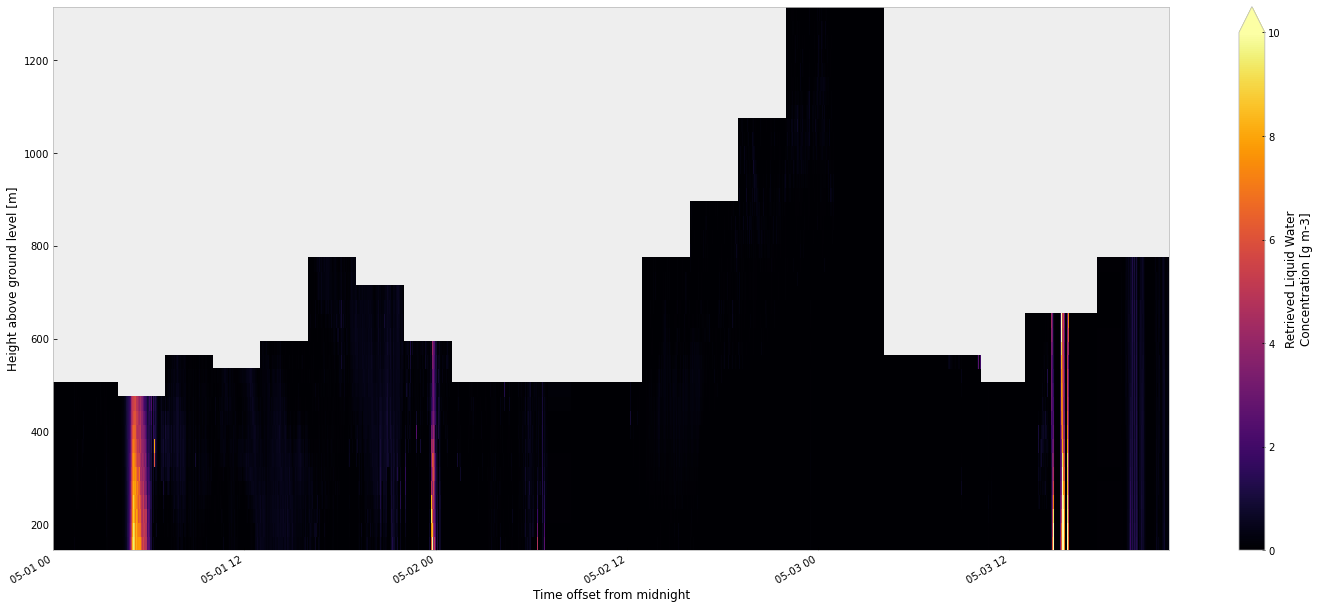

In [350]:
import matplotlib.colors as colors
xr.plot.pcolormesh(micro_pbl_neutrl['liquid_water_content'],'time','height',figsize=(25,10),vmin=0, vmax=10,cmap='inferno')

Text(0, 0.5, 'Number Total')

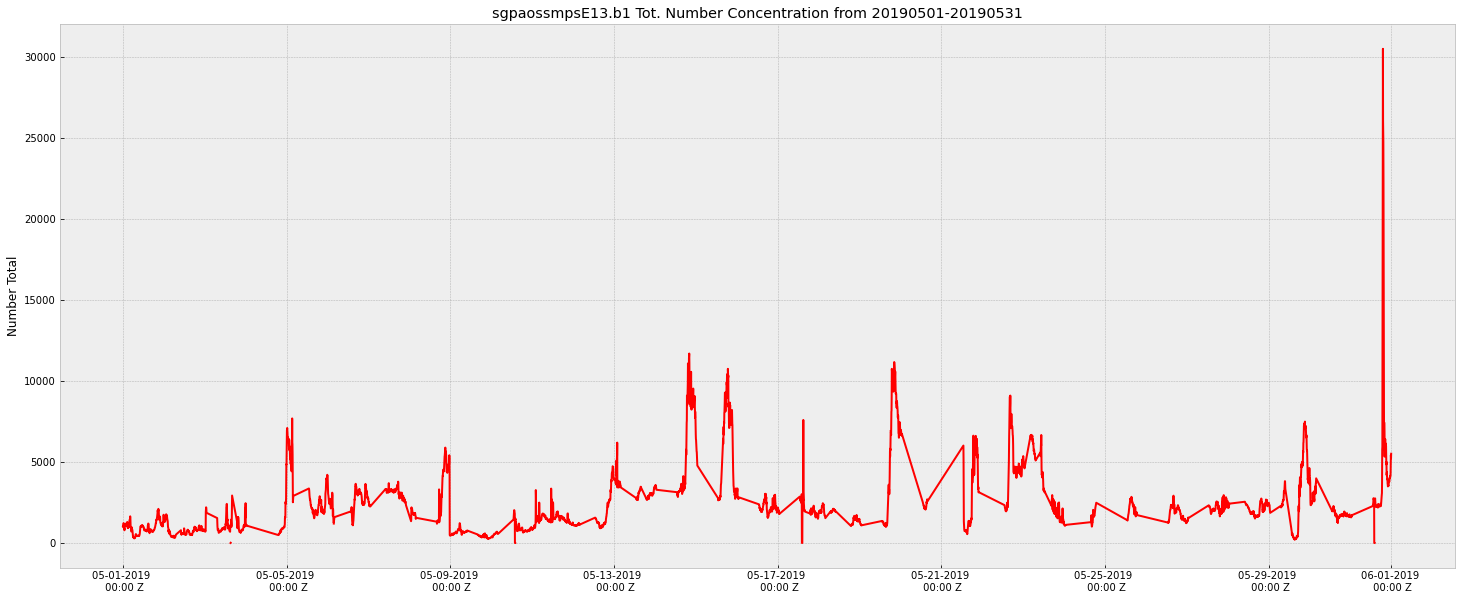

In [327]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("bmh")
fig,ax = plt.subplots(1,1,figsize=(25,10))
ax.plot(obj2['time'],obj2['total_N_conc'], color = 'red', label='number conc',zorder=2)
ax.set_title("sgpaossmpsE13.b1 Tot. Number Concentration from 20190501-20190531")
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m-%d-%Y \n %H:%M Z'))
ax.set_ylabel('Number Total')

In [298]:
micro_pbl_neutrl.to_netcdf(out_dir+microbase_out,format='NETCDF4')  

C:\Users\Reese\anaconda3\lib\site-packages\xarray\conventions.py:445: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bounds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(
<ipython-input-298-6d86e6c31b0c>:1: SerializationWarning: saving variable qc_liquid_water_content with floating point data as an integer dtype without any _FillValue to use for NaNs
  micro_pbl_neutrl.to_netcdf(r'C:\Users\Reese\Desktop\AOS Proj Data\Ouput_Files\Microbase_Neu_ABL.nc',format='NETCDF4')
<ipython-input-298-6d86e6c31b0c>:1: SerializationWarning: saving variable aqc_liquid_water_content with floating point data as an integer dtype without any _FillValue to use for NaNs
  micro_pbl_neutrl.to_netcdf(r'C:\Users\Reese\Desktop\AOS Proj Data\Ouput_Files\Microbase_Neu_A

### When we move to the large scale (year worth of data) consider looping a day at a time
-- Time extraction into one file (still need b4 and aftr because tolerance didnt work as we'd hoped) --do all of this for one year

--Then loop through each big data file, apply the time, and then write that one data file back out (do this for each day or for a month at a time [considering monthly analysis]).

--I know we discussed ridding ourselves of python loops because they are slow but certian operations seems to need them.

--create subdirectory to output to that will help keep things organized. Data is in a different directory than code. Input data in different directory than output data. This will help manage the large number of files we will eventually be processing

-- Make sure we are aware of which version of python will be run when executing in commmand line

-- Ken mentioned using the ACT reader when coming onto the server...Now that I have that working as it should, what all adjustments do I need to be making to the code? Just reading in using the ACT reader as opposed to xr.ope_mfdataset (ACT reader is wrapper for this). Talked about new keywords being easier.